# Looking at bit collisions in Morgan fingerprints

In the group over the past few days we've had a few conversations about bit collisions in Morgan fingerprints. These happen when we fold the fingerprints to be a particular size if two different bits (corresponding to two different atom environments) end up folding onto the same bit.

This post is an exploration of how often that happens. I will look at fingerprints with different radii -- 1, 2, and 3 -- folded to a set of different sizes -- 1K, 2K, 4K, 8K.

TL;DR version: There are a fair number of collisions at fingerprint sizes below 4K. As expected, higher radii have more collisions. The collisions don't end up making much difference in terms of calculated similarity, but we have observed (not shown here) that it can make a measurable difference in the performance of some machine-learning algorithms.


In [1]:
from rdkit import Chem
import time,random
import numpy as np
from collections import defaultdict
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem import rdMolProcessing
from rdkit.Chem import rdFingerprintGenerator
from rdkit import rdBase
rdBase.DisableLog('rdApp.*')
import rdkit

print(rdkit.__version__)
import time
print(time.asctime())

2024.09.5
Fri Feb 28 06:58:42 2025


In [2]:
import chembl_downloader

In [3]:
chembl_downloader.download_sdf()

PosixPath('/home/glandrum/.data/chembl/35/chembl_35.sdf.gz')

For test data I'll use all compounds from ChEMBL35 that have less than 50 heavy atoms.

Loop over the molecules and build fingerprints of multiple radii and folded lengths.

In [4]:
counts=defaultdict(list)

rs = (0,1,2,3)
sizes= (512,1024,2048,4096,8192)
fpgs = []
for r in rs:
    for sz in sizes:
        fpgs.append((r,sz,rdFingerprintGenerator.GetMorganGenerator(radius=r,fpSize=sz)))
                    
suppl = Chem.MultithreadedSDMolSupplier('/home/glandrum/.data/chembl/35/chembl_35.sdf',numWriterThreads=8)
for i,m in enumerate(suppl):
    if not m: 
        continue
    if m.GetNumHeavyAtoms() > 50:
        continue
    for r,sz,fpg in fpgs:
        if sz==sizes[0]:
            # get the unfolded fingerprint:
            counts[(r,-1)].append(len(fpg.GetSparseCountFingerprint(m).GetNonzeroElements()))
        counts[(r,sz)].append(fpg.GetFingerprint(m).GetNumOnBits())
    if not (i+1)%50000:
        print("Done {0}".format(i+1))

Done 50000
Done 100000
Done 150000
Done 200000
Done 250000
Done 350000
Done 400000
Done 450000
Done 500000
Done 550000
Done 600000
Done 650000
Done 700000
Done 750000
Done 800000
Done 850000
Done 900000
Done 950000
Done 1000000
Done 1050000
Done 1100000
Done 1150000
Done 1200000
Done 1250000
Done 1300000
Done 1350000
Done 1400000
Done 1450000
Done 1500000
Done 1550000
Done 1600000
Done 1650000
Done 1700000
Done 1750000
Done 1800000
Done 1850000
Done 1900000
Done 1950000
Done 2000000
Done 2050000
Done 2100000
Done 2150000
Done 2200000
Done 2250000
Done 2300000
Done 2350000
Done 2400000
Done 2450000


Now plot histograms of the numbers of collisions along with the fractions of collisions.

The two plots in each row show the same data, the left one uses counts of collisions, the right is the fraction of bits that are collisions. The right plots also include lines showing what fraction of fingerprints have at least that fraction of collisions.

In [5]:
import pickle
import gzip
with gzip.open('./results/bit_counts.pkl.gz','wb+') as outf:
    pickle.dump(counts,outf)

In [6]:
from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
%matplotlib inline

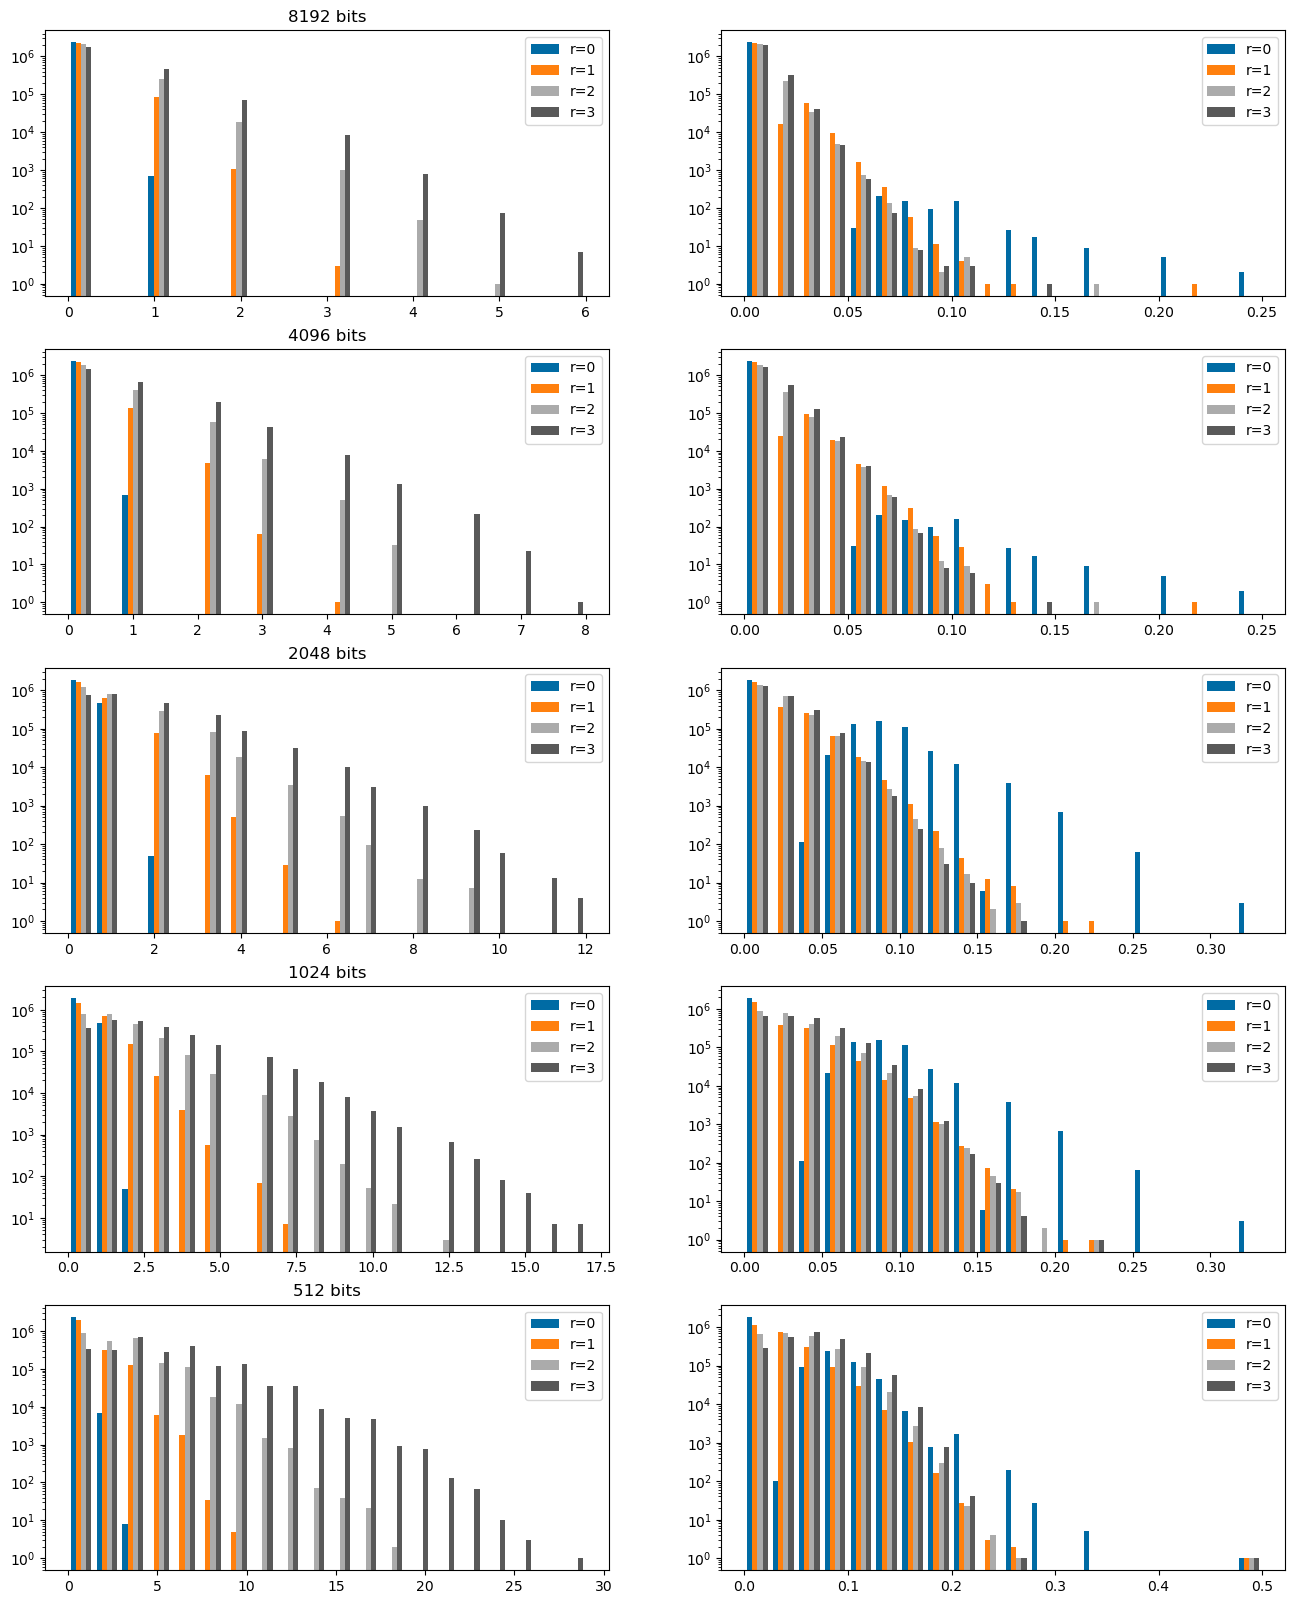

In [20]:
plt.figure(figsize=(16,20))

pidx=1
#----------------------------
for nbits in (8192,4096,2048,1024,512):
    plt.subplot(5,2,pidx)
    pidx+=1
    ds = []
    dps = []
    for r in (0,1,2,3):
        v1=np.array(counts[r,-1])
        v2=np.array(counts[r,nbits])
        d = v1-v2
        dp=np.array(d,float)
        dp/=v1
        ds.append(d)
        dps.append(dp)
    
    _=plt.hist(ds,bins=20,log=True,label=("r=0", "r=1","r=2","r=3"))
    plt.title('%d bits'%nbits)
    _=plt.legend()
    
    plt.subplot(5,2,pidx)
    pidx+=1
    _=plt.hist(dps,bins=20,log=True,label=("r=0","r=1","r=2","r=3"))
    _=plt.legend()




So, there are definitely some collisions.

Do they make a difference in similarity values? Look at 10K random molecule pairs to find out.

In [5]:
random.seed(0xF00D)
smis = [x.split()[0] for x in file(filen)]
ivs=[random.randint(0,len(smis)-1) for x in range(10000)]
jvs=[random.randint(0,len(smis)-1) for x in range(10000)]
pairs=zip(ivs,jvs)

sims=defaultdict(list)
for i,j in pairs:
    mi = Chem.MolFromSmiles(smis[i])
    if not mi:
        continue
    mj = Chem.MolFromSmiles(smis[j])
    if not mj:
        continue
    for r in 0,1,2,3:
        fpi=rdmd.GetMorganFingerprint(mi,r)
        for k,v in fpi.GetNonzeroElements().items():
            fpi[k]=1
        fpj=rdmd.GetMorganFingerprint(mj,r)
        for k,v in fpj.GetNonzeroElements().items():
            fpj[k]=1
        sims[(r,-1)].append(DataStructs.TanimotoSimilarity(fpi,fpj))
        for l in 1024,2048,4096,8192:
            fpi=rdmd.GetMorganFingerprintAsBitVect(mi,r,l)
            fpj=rdmd.GetMorganFingerprintAsBitVect(mj,r,l)
            sims[(r,l)].append(DataStructs.TanimotoSimilarity(fpi,fpj))

-c:12: RuntimeWarning: invalid value encountered in divide
-c:17: RuntimeWarning: divide by zero encountered in divide
-c:17: RuntimeWarning: invalid value encountered in divide
-c:22: RuntimeWarning: divide by zero encountered in divide
-c:22: RuntimeWarning: invalid value encountered in divide
-c:12: RuntimeWarning: divide by zero encountered in divide


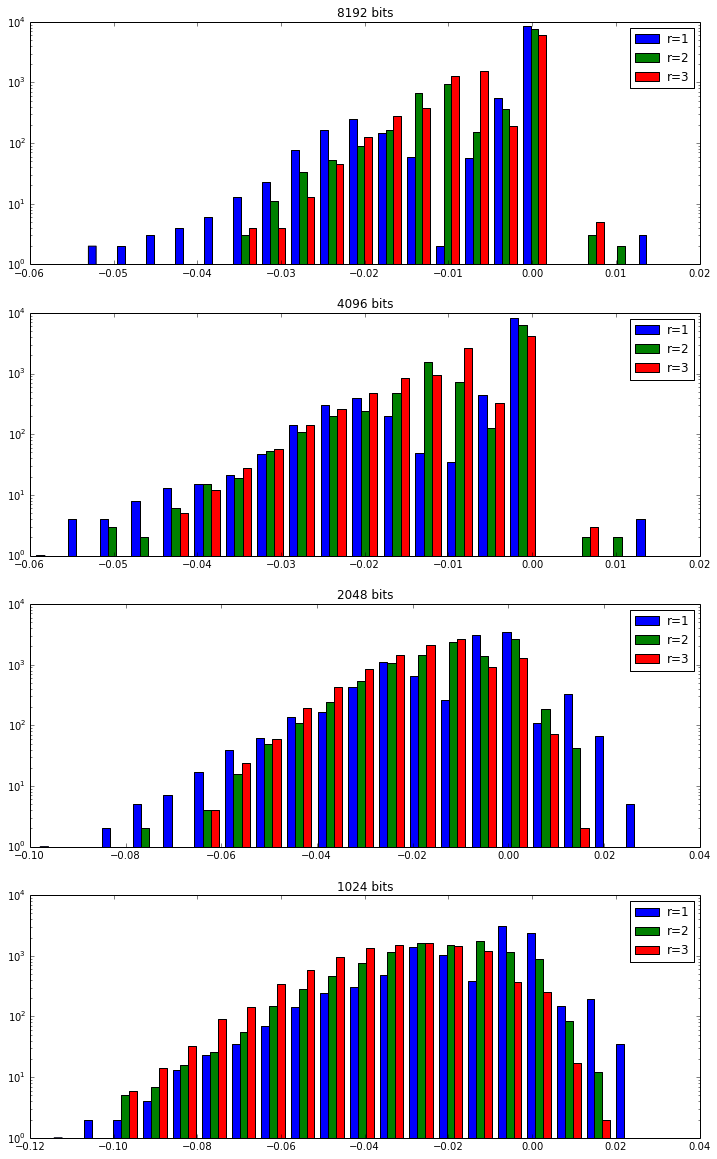

In [6]:
figure(figsize=(12,20))

pidx=1
#----------------------------
for nbits in (8192,4096,2048,1024):
    subplot(4,1,pidx)
    pidx+=1
    v1=np.array(sims[1,-1])
    v2=np.array(sims[1,nbits])
    d1 = v1-v2
    d1p=np.array(d1,np.float)
    d1p/=v1
    v1=np.array(sims[2,-1])
    v2=np.array(sims[2,nbits])
    d2 = v1-v2
    d2p=np.array(d2,np.float)
    d2p/=v1
    v1=np.array(sims[3,-1])
    v2=np.array(sims[3,nbits])
    d3 = v1-v2
    d3p=np.array(d3,np.float)
    d3p/=v1
    
    _=hist((d1,d2,d3),bins=20,log=True,label=("r=1","r=2","r=3"))
    title('%d bits'%nbits)
    _=legend()
    



The changes in similarity are very minimal.